In [1]:
# Cell 1: Data Loading and Preprocessing Functions


# This notebook implements a comprehensive ML model for classifying normal vs abnormal heart sounds
# using audio recordings from 4 auscultation locations and patient demographics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import pandas as pd
import numpy as np
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

CLIP_LENGTH = 3  # seconds

class AudioPreprocessor:
    """Handles audio preprocessing including bandpass filtering and mel-spectrogram generation"""
    
    def __init__(self, sample_rate=4000, n_mels=128, n_fft=1024, hop_length=512, 
                 normalization_method='minmax'): #zscore #minmax #robust #global_stats
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.normalization_method = normalization_method

    def bandpass_filter(self, audio, lowcut=25, highcut=800):
        """Apply bandpass filter to remove noise"""
        from scipy import signal
        nyquist = 0.5 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(4, [low, high], btype='band')
        return signal.filtfilt(b, a, audio)
    
    def split_into_5s_clips(self, audio, sample_rate):
        """Split audio into 5-second clips, discarding remainder"""
        clip_length = CLIP_LENGTH * sample_rate
        n_clips = len(audio) // clip_length
        clips = []
        for i in range(n_clips):
            start = i * clip_length
            end = start + clip_length
            clips.append(audio[start:end])
        return clips
    
    def audio_to_melspec(self, audio):
        """Convert audio to mel-log spectrogram"""
        # Apply bandpass filter
        filtered_audio = self.bandpass_filter(audio)
        
        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=filtered_audio,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        
        # Convert to log scale
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                # Apply normalization based on chosen method
        if self.normalization_method == 'zscore':
            # Z-score normalization (zero mean, unit variance) - Most common for CNNs
            log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / (np.std(log_mel_spec) + 1e-8)
            
        elif self.normalization_method == 'minmax':
            # Min-Max normalization to [0, 1] range
            min_val = np.min(log_mel_spec)
            max_val = np.max(log_mel_spec)
            log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val + 1e-8)
            
        elif self.normalization_method == 'robust':
            # Robust normalization using percentiles (less sensitive to outliers)
            p5, p95 = np.percentile(log_mel_spec, [5, 95])
            log_mel_spec = np.clip((log_mel_spec - p5) / (p95 - p5 + 1e-8), 0, 1)
            
        elif self.normalization_method == 'global_stats':
            # Global normalization using dataset statistics (would need to be computed first)
            # This is a placeholder - you'd need to compute these stats from your training data
            # global_mean, global_std = compute_dataset_stats()  # Implement this function
            # log_mel_spec = (log_mel_spec - global_mean) / (global_std + 1e-8)
            pass
        
        # If normalization_method == 'none', no normalization is applied
        
        return log_mel_spec

    def compute_dataset_statistics(self, patients_data, num_samples=1000):
        """Compute global mean and std from a subset of the dataset for global normalization"""
        print("Computing dataset statistics for normalization...")
        
        all_spectrograms = []
        sample_count = 0
        
        for patient in tqdm(patients_data[:num_samples], desc="Computing stats"):
            if sample_count >= num_samples:
                break
                
            recordings = patient.get('recordings', {})
            for location in ['AV', 'PV', 'TV', 'MV']:
                if location in recordings:
                    for audio_file in recordings[location]:
                        try:
                            audio, sr = librosa.load(audio_file, sr=self.sample_rate)
                            clips = self.split_into_5s_clips(audio, sr)
                            
                            for clip in clips[:2]:  # Only use first 2 clips per file to save memory
                                # Apply preprocessing without normalization
                                temp_method = self.normalization_method
                                self.normalization_method = 'none'
                                mel_spec = self.audio_to_melspec(clip)
                                self.normalization_method = temp_method
                                
                                all_spectrograms.append(mel_spec)
                                sample_count += 1
                                
                                if sample_count >= num_samples:
                                    break
                            
                            if sample_count >= num_samples:
                                break
                        except Exception as e:
                            continue
                    
                    if sample_count >= num_samples:
                        break
                
                if sample_count >= num_samples:
                    break
        
        if all_spectrograms:
            # Concatenate all spectrograms and compute global statistics
            all_data = np.concatenate([spec.flatten() for spec in all_spectrograms])
            global_mean = np.mean(all_data)
            global_std = np.std(all_data)
            
            print(f"Dataset statistics computed from {len(all_spectrograms)} spectrograms:")
            print(f"Global mean: {global_mean:.4f}")
            print(f"Global std: {global_std:.4f}")
            
            return global_mean, global_std
        else:
            print("Warning: No spectrograms found for statistics computation")
            return 0.0, 1.0

def parse_patient_file(file_path):
    """Parse patient .txt file to extract demographics and labels"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    patient_info = {}
    # Parse first line: subject_id, num_recordings, sample_rate
    first_line = lines[0].strip().split()
    patient_info['subject_id'] = first_line[0]
    patient_info['num_recordings'] = int(first_line[1])
    patient_info['sample_rate'] = int(first_line[2])
    
    # Parse recording files info
    recordings = []
    for i in range(1, patient_info['num_recordings'] + 1):
        parts = lines[i].strip().split()
        recordings.append({
            'location': parts[0],
            'hea_file': parts[1],
            'wav_file': parts[2],
            'tsv_file': parts[3]
        })
    patient_info['recordings'] = recordings
    
    # Parse metadata
    for line in lines[patient_info['num_recordings'] + 1:]:
        if line.startswith('#'):
            key_value = line[1:].strip().split(': ', 1)
            if len(key_value) == 2:
                key, value = key_value
                if value != 'nan':
                    patient_info[key.lower().replace(' ', '_')] = value
                else:
                    patient_info[key.lower().replace(' ', '_')] = None
    
    return patient_info

def load_dataset(data_dir):
    """Load entire dataset and create structured dataframe"""
    data_dir = Path(data_dir)
    patients_data = []
    
    # Get all patient .txt files
    patient_files = list(data_dir.glob("*.txt"))
    
    for patient_file in tqdm(patient_files, desc="Loading patient data"):
        try:
            patient_info = parse_patient_file(patient_file)
            
            # Extract key demographic features
            demographics = {
                'subject_id': patient_info['subject_id'],
                'age': patient_info.get('age'),
                'sex': patient_info.get('sex'),
                'height': patient_info.get('height'),
                'weight': patient_info.get('weight'),
                'pregnancy_status': patient_info.get('pregnancy_status'),
                'outcome': patient_info.get('outcome'),  # Normal/Abnormal
                'murmur': patient_info.get('murmur')     # Present/Absent/Unknown
            }
            
            # Add recording file paths
            recordings_by_location = {}
            for rec in patient_info['recordings']:
                location = rec['location']
                if location in ['AV', 'PV', 'TV', 'MV']:  # Only use main 4 locations
                    if location not in recordings_by_location:
                        recordings_by_location[location] = []
                    recordings_by_location[location].append(data_dir / rec['wav_file'])
            
            demographics['recordings'] = recordings_by_location
            patients_data.append(demographics)
            
        except Exception as e:
            print(f"Error processing {patient_file}: {e}")
            continue
    
    return patients_data


In [2]:
# Cell 2: Dataset Class

class HeartSoundDataset(Dataset):
    """Dataset class for heart sound classification"""
    
    def __init__(self, patients_data, preprocessor=None, demographic_scaler=None):
        self.patients_data = patients_data
        self.preprocessor = preprocessor if preprocessor else AudioPreprocessor()
        self.demographic_scaler = demographic_scaler
        self.locations = ['AV', 'PV', 'TV', 'MV']
        
        # Filter out patients without outcome labels
        self.valid_patients = [p for p in patients_data if p.get('outcome') in ['Normal', 'Abnormal']]
        
    def __len__(self):
        return len(self.valid_patients)
    
    def __getitem__(self, idx):
        patient = self.valid_patients[idx]

        # Process audio for each location
        location_embeddings = {}
        
        for location in self.locations:
            if location in patient.get('recordings', {}):
                # Get all recordings for this location
                recording_files = patient['recordings'][location]
                
                all_clips_embeddings = []
                
                for audio_file in recording_files:
                    try:
                        # Load audio
                        audio, sr = librosa.load(audio_file, sr=self.preprocessor.sample_rate)
                        
                        # Split into 5-second clips
                        clips = self.preprocessor.split_into_5s_clips(audio, sr)
                        
                        # Process each clip
                        for clip in clips:
                            mel_spec = self.preprocessor.audio_to_melspec(clip)
                            # Convert to tensor and add channel dimension
                            mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0)
                            all_clips_embeddings.append(mel_tensor)
                            
                    except Exception as e:
                        print(f"Error processing {audio_file}: {e}")
                        continue
                
                if all_clips_embeddings:
                    # Stack all clips for this location
                    location_embeddings[location] = torch.stack(all_clips_embeddings)
                else:
                    # Create dummy tensor if no valid clips
                    location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                              self.preprocessor.n_mels)
            else:
                # Create dummy tensor for missing location
                location_embeddings[location] = torch.zeros(1, 1, self.preprocessor.n_mels, 
                                                          self.preprocessor.n_mels)
        
        # Process demographics
        demographics = self.process_demographics(patient)
        
        # Create label (1 for Abnormal, 0 for Normal)
        label = 1 if patient['outcome'] == 'Abnormal' else 0
        
        return location_embeddings, demographics, label
    
    def process_demographics(self, patient):
        """Process demographic information into numerical features"""
        # Extract and encode demographic features
        features = []
        
        # Height (convert to float or use median if missing)
        try:
            height = float(patient.get('height', 120.0))  # median height in dataset
        except (ValueError, TypeError):
            height = 120.0
        features.append(height)
        
        # Weight (convert to float or use median if missing)
        try:
            weight = float(patient.get('weight', 25.0))  # median weight in dataset
        except (ValueError, TypeError):
            weight = 25.0
        features.append(weight)
        
        # Sex (0 for Female, 1 for Male)
        sex = 1 if patient.get('sex') == 'Male' else 0
        features.append(sex)
        
        # Age (encode age categories as numerical)
        age_mapping = {
            'Neonate': 0, 'Infant': 1, 'Child': 2, 
            'Adolescent': 3, 'Young Adult': 4
        }
        age = age_mapping.get(patient.get('age'), 2)  # default to Child
        features.append(age)
        
        # Pregnancy status (0 for False/None, 1 for True)
        pregnancy = 1 if patient.get('pregnancy_status') == 'True' else 0
        features.append(pregnancy)
        
        demographics_tensor = torch.FloatTensor(features)
        
        # Apply scaling if scaler is provided
        # if self.demographic_scaler:
        #     demographics_tensor = torch.FloatTensor(
        #         self.demographic_scaler.transform(features.reshape(1, -1)).flatten()
        #     )

        if self.demographic_scaler:
            features_np = np.array(features).reshape(1, -1)
            demographics_tensor = torch.FloatTensor(
                self.demographic_scaler.transform(features_np).flatten()
            )
        
        return demographics_tensor

In [3]:
# Cell 3: Neural Network Models



class AudioCNN(nn.Module):
    """CNN for processing individual audio clips (mel-spectrograms)"""
    
    def __init__(self, input_channels=1, embedding_dim=128):
        super(AudioCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25/2),
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Dropout(0.5/2)
        )
        
        # Calculate the flattened size
        self.flattened_size = 256 * 4 * 4
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

class DemographicMLP(nn.Module):
    """MLP for processing demographic features"""
    
    def __init__(self, input_dim=5, embedding_dim=128):
        super(DemographicMLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3/2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3/2),
            nn.Linear(128, embedding_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    """Multi-head attention mechanism for combining location embeddings"""
    
    def __init__(self, embed_dim=128, num_heads=8, ff_dim=512, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        #self.layer_norm = nn.LayerNorm(embed_dim)
        # CHAT SUGG 2
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

    # def forward(self, x):
    #     # x shape: (batch_size, num_locations, embed_dim)
    #     attn_output, attn_weights = self.multihead_attn(x, x, x)
    #     # Add residual connection and layer normalization
    #     output = self.layer_norm(x + attn_output)
    #     return output
    
    # def forward(self, x):
    #     # x shape: (batch_size, num_locations, embed_dim)
    #     attn_output, attn_weights = self.multihead_attn(x, x, x)
    #     # Add residual connection and layer normalization
    #     output = self.layer_norm(x + attn_output)
    #     return output, attn_weights

    # # CHAT GPT SUGGESTION 1
    # def forward(self, x): 
    #     x_norm = self.layer_norm(x)
    #     attn_output, attn_weights = self.multihead_attn(x_norm, x_norm, x_norm)
    #     output = x + attn_output
    #     return output, attn_weights

    # CHAT GPT SUGGESTION 2
    def forward(self, x):
        # ---- Multi-head attention sublayer ----
        # Pre-LN
        x_norm = self.layer_norm1(x)
        attn_output, attn_weights = self.multihead_attn(x_norm, x_norm, x_norm)
        x = x + attn_output  # Residual connection

        # ---- Feed-forward sublayer ----
        x_norm = self.layer_norm2(x)
        ff_output = self.ffn(x_norm)
        x = x + ff_output  # Residual connection

        return x, attn_weights

In [4]:

# Cell 4: Training and Evaluation Functions

def custom_collate_fn(batch):
    """Custom collate function to handle variable number of clips per location"""
    location_data = {loc: [] for loc in ['AV', 'PV', 'TV', 'MV']}
    demographics = []
    labels = []
    
    for location_dict, demo, label in batch:
        # Collect demographics and labels
        demographics.append(demo)
        labels.append(label)
        
        # Collect location data
        for loc in ['AV', 'PV', 'TV', 'MV']:
            location_data[loc].append(location_dict[loc])
    
    # Stack tensors
    demographics_tensor = torch.stack(demographics)
    labels_tensor = torch.LongTensor(labels)
    
    return location_data, demographics_tensor, labels_tensor

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0


    for batch_idx, (location_data, demographics, labels) in enumerate(tqdm(train_loader, desc="Training")):

        # Move data to device
        demographics = demographics.to(device)
        labels = labels.to(device)
        
        # Move location data to device
        for loc in location_data:
            for i in range(len(location_data[loc])):
                location_data[loc][i] = location_data[loc][i].to(device)

        optimizer.zero_grad()


        # Forward pass
        outputs = model(location_data, demographics)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for location_data, demographics, labels in tqdm(test_loader, desc="Evaluating"):
            # Move data to device
            demographics = demographics.to(device)
            labels = labels.to(device)
            
            # Move location data to device
            for loc in location_data:
                for i in range(len(location_data[loc])):
                    location_data[loc][i] = location_data[loc][i].to(device)

            
            
            # Forward pass
            outputs = model(location_data, demographics)
            loss = criterion(outputs, labels)
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Store predictions and labels for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy, all_predictions, all_labels

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plot training history"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [5]:

# Cell 5: Main Training Pipeline

def main_training_pipeline(data_dir, batch_size=8, num_epochs=50, learning_rate=0.001):
    """Complete training pipeline"""
    
    print("Loading dataset...")
    patients_data = load_dataset(data_dir)
    print(f"Loaded {len(patients_data)} patients")
    
    # Split data into train, validation, and test sets
    train_data, temp_data = train_test_split(patients_data, test_size=0.4, random_state=42, 
                                           stratify=[p.get('outcome', 'Unknown') for p in patients_data])
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42,
                                         stratify=[p.get('outcome', 'Unknown') for p in temp_data])
    
    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")
    
    # Initialize preprocessor
    preprocessor = AudioPreprocessor(normalization_method='zscore')
    
    # Prepare demographic scaler
    all_demographics = []
    for patient in train_data:
        if patient.get('outcome') in ['Normal', 'Abnormal']:
            # Extract demographic features for scaling
            features = []
            features.append(float(patient.get('height', 120.0)) if patient.get('height') else 120.0)
            features.append(float(patient.get('weight', 25.0)) if patient.get('weight') else 25.0)
            features.append(1 if patient.get('sex') == 'Male' else 0)
            age_mapping = {'Neonate': 0, 'Infant': 1, 'Child': 2, 'Adolescent': 3, 'Young Adult': 4}
            features.append(age_mapping.get(patient.get('age'), 2))
            features.append(1 if patient.get('pregnancy_status') == 'True' else 0)
            all_demographics.append(features)
    
    demographic_scaler = StandardScaler()
    demographic_scaler.fit(all_demographics)
    
    # Create datasets
    train_dataset = HeartSoundDataset(train_data, preprocessor, demographic_scaler)
    val_dataset = HeartSoundDataset(val_data, preprocessor, demographic_scaler)
    test_dataset = HeartSoundDataset(test_data, preprocessor, demographic_scaler)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            collate_fn=custom_collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          collate_fn=custom_collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                           collate_fn=custom_collate_fn, num_workers=0)

    # Initialize model
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = HeartSoundClassifier(embedding_dim=128, num_classes=2)
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    patience_counter = 0
    patience_limit = 10
    
    print("Starting training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validate
        val_loss, val_acc, val_predictions, val_labels = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_labels, val_predictions, 
                                target_names=['Normal', 'Abnormal']))
        
        # Early stopping
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_heart_sound_model.pth')
            print(f"New best validation accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load('best_heart_sound_model.pth'))
    
    # Final test evaluation
    print("\nEvaluating on test set...")
    test_loss, test_acc, test_predictions, test_labels = evaluate_model(model, test_loader, criterion, device)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions, 
                              target_names=['Normal', 'Abnormal']))
    
    # Plot results
    plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)
    plot_confusion_matrix(test_labels, test_predictions)
    viz = quick_visualization_setup(model, device, test_loader)

    return model, preprocessor, demographic_scaler, viz


def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Abnormal']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()#, attn_weights

class HeartSoundClassifier(nn.Module):
    """Complete heart sound classification model"""
    
    def __init__(self, embedding_dim=128, num_classes=2):
        super(HeartSoundClassifier, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.locations = ['AV', 'PV', 'TV', 'MV']
        
        # CNN for processing audio clips
        self.audio_cnn = AudioCNN(embedding_dim=embedding_dim)
        
        # MLP for processing demographics
        self.demographic_mlp = DemographicMLP(embedding_dim=embedding_dim)
        
        # Attention mechanism
        self.attention = MultiHeadAttention(embed_dim=embedding_dim)
        
        # Final classification layers
        # 5 embeddings (4 locations + demographics) * embedding_dim
        self.classifier = nn.Sequential(
            nn.Linear(5 * embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, location_data, demographics):
        batch_size = demographics.size(0)
        location_embeddings = []
        
        # Process each location
        for location in self.locations:
            location_clips = location_data[location]  # Shape: (batch_size, num_clips, channels, height, width)
            
            # Process all clips for this location in the batch
            batch_location_embeddings = []
            
            for b in range(batch_size):
                clips = location_clips[b]  # Shape: (num_clips, channels, height, width)
                
                if clips.size(0) > 0:
                    # Process all clips through CNN
                    clip_embeddings = self.audio_cnn(clips)  # Shape: (num_clips, embedding_dim)
                    # Take mean across clips to get location embedding
                    location_embedding = clip_embeddings.mean(dim=0)  # Shape: (embedding_dim,) #YOSSI CHANGE
                    #location_embedding, _ = torch.max(clip_embeddings, dim=0) #CHAT SUGGESTIONS
                    #print(f"first 5 {clip_embeddings[:,0:5]}, mean: {location_embedding[0:5]}")
                    #location_embedding = clip_embeddings[0]  # Shape: (embedding_dim,)
                else:
                    # Handle case where no clips are available
                    location_embedding = torch.zeros(self.embedding_dim, device=demographics.device)
                
                batch_location_embeddings.append(location_embedding)
            
            # Stack embeddings for all samples in batch
            batch_location_tensor = torch.stack(batch_location_embeddings)  # Shape: (batch_size, embedding_dim)
            location_embeddings.append(batch_location_tensor)
        
        # Process demographics
        demographic_embeddings = self.demographic_mlp(demographics)  # Shape: (batch_size, embedding_dim)
        
        # Combine all embeddings
        all_embeddings = location_embeddings + [demographic_embeddings]
        combined_embeddings = torch.stack(all_embeddings, dim=1)  # Shape: (batch_size, 5, embedding_dim)
        
        # Apply attention
        attended_embeddings, attention_weights = self.attention(combined_embeddings)
        
        # Flatten for final classification
        flattened = attended_embeddings.view(batch_size, -1)  # Shape: (batch_size, 5 * embedding_dim)
        
        # Final classification
        output = self.classifier(flattened)
        
        return output

In [6]:
# Cell 6: Model Visualization Toolkit
# Comprehensive visualization for heart sound classification model

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.hooks import RemovableHandle
import cv2
from typing import Dict, List, Tuple, Optional

class ModelVisualizer:
    """Complete visualization toolkit for heart sound model"""
    
    def __init__(self, model, device, val_loader=None, test_loader=None):
        self.model = model
        self.device = device
        self.val_loader = val_loader
        self.test_loader = test_loader
        
        # Storage for activations and gradients
        self.activations = {}
        self.gradients = {}
        self.hooks = []
        
        # Cache for frequently used data
        self.cached_samples = None
        self.cached_labels = None
        self.cached_predictions = None
        
        print(f"ModelVisualizer initialized with device: {device}")
        if val_loader:
            print(f"Validation loader: {len(val_loader)} batches")
        if test_loader:
            print(f"Test loader: {len(test_loader)} batches")
    
    def cache_samples(self, num_samples=20, use_test=False):
        """Cache samples for quick visualization without reloading"""
        loader = self.test_loader if use_test else self.val_loader
        if loader is None:
            print("No data loader available!")
            return
            
        print(f"Caching {num_samples} samples...")
        
        all_location_data = {loc: [] for loc in ['AV', 'PV', 'TV', 'MV']}
        all_demographics = []
        all_labels = []
        all_predictions = []
        
        self.model.eval()
        samples_collected = 0
        
        with torch.no_grad():
            for location_data, demographics, labels in loader:
                if samples_collected >= num_samples:
                    break
                    
                # Move to device
                demographics = demographics.to(self.device)
                labels = labels.to(self.device)
                
                for loc in location_data:
                    for i in range(len(location_data[loc])):
                        location_data[loc][i] = location_data[loc][i].to(self.device)
                
                # Get predictions
                outputs = self.model(location_data, demographics)
                _, predicted = torch.max(outputs.data, 1)
                
                # Store data
                batch_size = min(labels.size(0), num_samples - samples_collected)
                for i in range(batch_size):
                    # Store location data
                    for loc in ['AV', 'PV', 'TV', 'MV']:
                        all_location_data[loc].append(location_data[loc][i])
                    
                    all_demographics.append(demographics[i])
                    all_labels.append(labels[i].item())
                    all_predictions.append(predicted[i].item())
                    
                    samples_collected += 1
                    if samples_collected >= num_samples:
                        break
        
        self.cached_samples = all_location_data
        self.cached_demographics = torch.stack(all_demographics)
        self.cached_labels = all_labels
        self.cached_predictions = all_predictions
        
        print(f"Cached {len(self.cached_labels)} samples")
        print(f"Normal: {sum(1 for l in all_labels if l == 0)}, Abnormal: {sum(1 for l in all_labels if l == 1)}")
    
    def register_hooks(self):
        """Register hooks to capture activations and gradients"""
        self.clear_hooks()
        
        def get_activation(name):
            def hook(model, input, output):
                if isinstance(output, tuple):
                    self.activations[name] = output[0].detach()
                else:
                    self.activations[name] = output.detach()
            return hook
        
        def get_gradient(name):
            def hook(model, grad_input, grad_output):
                if isinstance(grad_output[0], torch.Tensor):
                    self.gradients[name] = grad_output[0].detach()
            return hook
        
        # Register hooks for key layers
        layers_to_hook = {
            'cnn_conv1': self.model.audio_cnn.conv_layers[0],  # First conv layer
            'cnn_conv2': self.model.audio_cnn.conv_layers[4],  # Second conv layer  
            'cnn_conv3': self.model.audio_cnn.conv_layers[8],  # Third conv layer
            'cnn_conv4': self.model.audio_cnn.conv_layers[12], # Fourth conv layer
            'cnn_fc1': self.model.audio_cnn.fc_layers[0],      # First FC layer
            'cnn_output': self.model.audio_cnn.fc_layers[-1],  # CNN output
            'demo_mlp': self.model.demographic_mlp.layers[-1], # Demographics MLP output
            'attention': self.model.attention.multihead_attn,   # Attention layer
            'classifier': self.model.classifier[-1]            # Final classifier
        }
        
        for name, layer in layers_to_hook.items():
            handle = layer.register_forward_hook(get_activation(name))
            self.hooks.append(handle)
            handle = layer.register_backward_hook(get_gradient(name))
            self.hooks.append(handle)
    
    def clear_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}
        self.gradients = {}
    
    def visualize_attention_weights(self, sample_indices=None, num_samples=6):
        """Visualize attention weights for cached samples"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        if sample_indices is None:
            sample_indices = list(range(min(num_samples, len(self.cached_labels))))
        
        # Modify model to return attention weights
        original_forward = self.model.forward
        attention_weights_storage = []
        
        def forward_with_attention(location_data, demographics):
            batch_size = demographics.size(0)
            location_embeddings = []
            
            for location in self.model.locations:
                location_clips = location_data[location]
                batch_location_embeddings = []
                
                for b in range(batch_size):
                    clips = location_clips[b]
                    if clips.size(0) > 0:
                        clip_embeddings = self.model.audio_cnn(clips)
                        location_embedding = clip_embeddings.mean(dim=0)
                    else:
                        location_embedding = torch.zeros(self.model.embedding_dim, device=demographics.device)
                    batch_location_embeddings.append(location_embedding)
                
                batch_location_tensor = torch.stack(batch_location_embeddings)
                location_embeddings.append(batch_location_tensor)
            
            demographic_embeddings = self.model.demographic_mlp(demographics)
            all_embeddings = location_embeddings + [demographic_embeddings]
            combined_embeddings = torch.stack(all_embeddings, dim=1)
            
            attended_embeddings, attn_weights = self.model.attention(combined_embeddings)
            attention_weights_storage.extend(attn_weights.detach().cpu().numpy())
            
            flattened = attended_embeddings.view(batch_size, -1)
            output = self.model.classifier(flattened)
            return output
        
        self.model.forward = forward_with_attention
        
        # Process samples
        location_names = ['AV', 'PV', 'TV', 'MV', 'Demographics']
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        with torch.no_grad():
            for idx, sample_idx in enumerate(sample_indices[:6]):
                if idx >= len(axes):
                    break
                
                # Prepare single sample
                single_location_data = {}
                for loc in ['AV', 'PV', 'TV', 'MV']:
                    single_location_data[loc] = [self.cached_samples[loc][sample_idx].unsqueeze(0)]
                
                single_demographics = self.cached_demographics[sample_idx:sample_idx+1]
                
                # Forward pass
                _ = self.model(single_location_data, single_demographics)
                
                # Get attention weights
                attn = attention_weights_storage[idx]
                if len(attn.shape) == 3:
                    attn = attn.mean(axis=0)[0]
                elif len(attn.shape) == 2:
                    attn = attn[0]
                
                # Plot
                sns.heatmap(attn.reshape(1, -1), 
                           annot=True, fmt='.3f', cmap='viridis',
                           xticklabels=location_names, yticklabels=['Attention'],
                           ax=axes[idx], cbar_kws={'shrink': 0.8})
                
                true_label = "Normal" if self.cached_labels[sample_idx] == 0 else "Abnormal"
                pred_label = "Normal" if self.cached_predictions[sample_idx] == 0 else "Abnormal"
                
                axes[idx].set_title(f'Sample {sample_idx}\nTrue: {true_label}, Pred: {pred_label}')
        
        # Hide unused subplots
        for i in range(len(sample_indices), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('Attention Weights Visualization', fontsize=16, y=1.02)
        plt.show()
        
        # Restore original forward
        self.model.forward = original_forward
        
        return attention_weights_storage
    
    def visualize_cnn_features(self, sample_idx=0, location='AV', layer_name='cnn_conv3'):
        """Visualize CNN feature maps for a specific sample and location"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        self.register_hooks()
        self.model.eval()
        
        # Get sample
        clips = self.cached_samples[location][sample_idx]
        if clips.size(0) == 0:
            print(f"No clips available for location {location}")
            return
        
        # Forward pass through CNN only
        with torch.no_grad():
            _ = self.model.audio_cnn(clips)
        
        # Get activations
        if layer_name not in self.activations:
            print(f"Layer {layer_name} not found in activations")
            print(f"Available layers: {list(self.activations.keys())}")
            return
        
        features = self.activations[layer_name]
        
        # Plot feature maps
        if len(features.shape) == 4:  # Conv layer: [batch, channels, height, width]
            num_filters = min(16, features.shape[1])  # Show up to 16 filters
            fig, axes = plt.subplots(4, 4, figsize=(16, 16))
            axes = axes.flatten()
            
            for i in range(num_filters):
                feature_map = features[0, i].cpu().numpy()  # First clip, i-th filter
                
                im = axes[i].imshow(feature_map, cmap='viridis', aspect='auto')
                axes[i].set_title(f'Filter {i}')
                axes[i].axis('off')
                plt.colorbar(im, ax=axes[i], shrink=0.8)
            
            # Hide unused subplots
            for i in range(num_filters, len(axes)):
                axes[i].set_visible(False)
                
            plt.suptitle(f'CNN Features - {location} - {layer_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
            
        elif len(features.shape) == 2:  # FC layer: [batch, features]
            feature_vector = features[0].cpu().numpy()  # First clip
            
            plt.figure(figsize=(12, 4))
            plt.plot(feature_vector)
            plt.title(f'Feature Vector - {location} - {layer_name}')
            plt.xlabel('Feature Index')
            plt.ylabel('Activation Value')
            plt.grid(True)
            plt.show()
        
        self.clear_hooks()
    
    def compare_features_by_class(self, layer_name='cnn_output', location='AV'):
        """Compare feature distributions between Normal and Abnormal cases"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        self.register_hooks()
        self.model.eval()
        
        normal_features = []
        abnormal_features = []
        
        with torch.no_grad():
            for i, label in enumerate(self.cached_labels):
                clips = self.cached_samples[location][i]
                if clips.size(0) > 0:
                    _ = self.model.audio_cnn(clips)
                    
                    if layer_name in self.activations:
                        features = self.activations[layer_name][0].cpu().numpy()  # First clip
                        
                        if label == 0:
                            normal_features.append(features)
                        else:
                            abnormal_features.append(features)
        
        if normal_features and abnormal_features:
            normal_features = np.array(normal_features)
            abnormal_features = np.array(abnormal_features)
            
            # Plot feature distributions
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Average features
            axes[0].plot(np.mean(normal_features, axis=0), label='Normal', alpha=0.7)
            axes[0].plot(np.mean(abnormal_features, axis=0), label='Abnormal', alpha=0.7)
            axes[0].set_title('Average Feature Values')
            axes[0].set_xlabel('Feature Index')
            axes[0].set_ylabel('Mean Activation')
            axes[0].legend()
            axes[0].grid(True)
            
            # Feature variance
            axes[1].plot(np.std(normal_features, axis=0), label='Normal', alpha=0.7)
            axes[1].plot(np.std(abnormal_features, axis=0), label='Abnormal', alpha=0.7)
            axes[1].set_title('Feature Variance')
            axes[1].set_xlabel('Feature Index')
            axes[1].set_ylabel('Std Activation')
            axes[1].legend()
            axes[1].grid(True)
            
            # Feature difference
            diff = np.mean(abnormal_features, axis=0) - np.mean(normal_features, axis=0)
            axes[2].plot(diff, color='red', alpha=0.7)
            axes[2].set_title('Abnormal - Normal Difference')
            axes[2].set_xlabel('Feature Index')
            axes[2].set_ylabel('Difference')
            axes[2].grid(True)
            axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            plt.suptitle(f'Feature Analysis - {location} - {layer_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
        
        self.clear_hooks()
        return normal_features, abnormal_features
    
    def visualize_spectrograms(self, sample_indices=None, num_samples=4):
        """Visualize input spectrograms for different locations"""
        if self.cached_samples is None:
            print("No cached samples! Call cache_samples() first.")
            return
        
        if sample_indices is None:
            sample_indices = list(range(min(num_samples, len(self.cached_labels))))
        
        fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 4*len(sample_indices)))
        if len(sample_indices) == 1:
            axes = axes.reshape(1, -1)
        
        locations = ['AV', 'PV', 'TV', 'MV']
        
        for row, sample_idx in enumerate(sample_indices):
            for col, location in enumerate(locations):
                clips = self.cached_samples[location][sample_idx]
                
                if clips.size(0) > 0:
                    # Take first clip and remove channel dimension
                    spectrogram = clips[0, 0].cpu().numpy()
                    
                    im = axes[row, col].imshow(spectrogram, cmap='viridis', aspect='auto', origin='lower')
                    axes[row, col].set_title(f'{location} - Sample {sample_idx}')
                    axes[row, col].set_xlabel('Time')
                    axes[row, col].set_ylabel('Mel Frequency')
                    plt.colorbar(im, ax=axes[row, col], shrink=0.8)
                else:
                    axes[row, col].text(0.5, 0.5, 'No Data', ha='center', va='center', 
                                      transform=axes[row, col].transAxes)
                    axes[row, col].set_title(f'{location} - Sample {sample_idx}')
                
                true_label = "Normal" if self.cached_labels[sample_idx] == 0 else "Abnormal"
                if col == 0:  # Add label only to first column
                    axes[row, col].set_ylabel(f'{true_label}\nMel Frequency')
        
        plt.tight_layout()
        plt.suptitle('Input Spectrograms by Location', fontsize=16, y=1.02)
        plt.show()

# Usage Examples and Quick Commands
def quick_visualization_setup(model, device, val_loader=None, test_loader=None):
    """Quick setup for visualization"""
    viz = ModelVisualizer(model, device, val_loader, test_loader)
    viz.cache_samples(num_samples=50)
    
    print("\n" + "="*60)
    print("QUICK VISUALIZATION COMMANDS:")
    print("="*60)
    print("# Attention weights:")
    print("viz.visualize_attention_weights([0,1,2,3,4,5])")
    print()
    print("# CNN features for specific sample/location:")
    print("viz.visualize_cnn_features(sample_idx=0, location='AV', layer_name='cnn_conv3')")
    print()
    print("# Compare features between classes:")
    print("normal_feat, abnormal_feat = viz.compare_features_by_class('cnn_output', 'AV')")
    print()
    print("# View input spectrograms:")
    print("viz.visualize_spectrograms([0,1,2,3])")
    print()
    print("# Available CNN layers: 'cnn_conv1', 'cnn_conv2', 'cnn_conv3', 'cnn_conv4', 'cnn_fc1', 'cnn_output'")
    print("="*60)
    
    return viz

print("Model Visualization Toolkit Ready!")
print("Usage: viz = quick_visualization_setup(model, device, val_loader)")

Model Visualization Toolkit Ready!
Usage: viz = quick_visualization_setup(model, device, val_loader)


In [ ]:
# Cell 7: Usage Example

def predict_single_patient(model, preprocessor, demographic_scaler, patient_data, device):
    """Make prediction for a single patient"""
    model.eval()
    
    # Create dataset with single patient
    dataset = HeartSoundDataset([patient_data], preprocessor, demographic_scaler)
    
    if len(dataset) == 0:
        return None, "No valid data for prediction"
    
    # Get data
    location_data, demographics, _ = dataset[0]
    
    # Add batch dimension and move to device
    demographics = demographics.unsqueeze(0).to(device)
    
    # Prepare location data
    batch_location_data = {}
    for loc in ['AV', 'PV', 'TV', 'MV']:
        batch_location_data[loc] = [location_data[loc].to(device)]
    
    with torch.no_grad():
        outputs = model(batch_location_data, demographics)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    prediction = "Normal" if predicted.item() == 0 else "Abnormal"
    confidence = probabilities[0][predicted.item()].item()
    
    return prediction, confidence

# Example usage and training script
if __name__ == "__main__":
    # Set your data directory path here
    DATA_DIR = "C:\\Users\\Yosss\\Desktop\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\the-circor-digiscope-phonocardiogram-dataset-1.0.3\\training_data"
    
    # Check if directory exists (comment out if you want to skip this check)
    if not os.path.exists(DATA_DIR):
        print(f"Data directory {DATA_DIR} not found!")
        print("Please update DATA_DIR variable with the correct path to your CirCor dataset")
        print("\nTo use this code:")
        print("1. Download the CirCor dataset from PhysioNet")
        print("2. Extract it to a directory")
        print("3. Update the DATA_DIR variable above")
        print("4. Run the training pipeline")
        exit()
    
    # Run training pipeline
    try:
        trained_model, preprocessor, scaler, viz = main_training_pipeline(
            data_dir=DATA_DIR,
            batch_size=32,  # Adjust based on your GPU memory
            num_epochs=100,
            learning_rate=0.0001
        )
        
        print("Training completed successfully!")
        print("Model saved as 'best_heart_sound_model.pth'")
        
        # Example prediction (uncomment to use)
        # sample_patient = {
        #     'subject_id': '12345',
        #     'age': 'Child',
        #     'sex': 'Female', 
        #     'height': '120.0',
        #     'weight': '25.0',
        #     'pregnancy_status': 'False',
        #     'recordings': {
        #         'AV': ['/path/to/audio/file.wav'],
        #         # ... other locations
        #     }
        # }
        # 
        # prediction, confidence = predict_single_patient(
        #     trained_model, preprocessor, scaler, sample_patient, 
        #     torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # )
        # print(f"Prediction: {prediction}, Confidence: {confidence:.4f}")
        
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

Loading dataset...


Loading patient data: 100%|██████████| 942/942 [00:00<00:00, 3178.95it/s]


Loaded 942 patients
Train: 565, Validation: 188, Test: 189
Using device: cuda
Starting training...

Epoch 1/100
--------------------------------------------------


Training:   6%|▌         | 1/18 [00:03<01:06,  3.93s/it]

Batch 0/18, Loss: 0.6935


Training:  56%|█████▌    | 10/18 [00:19<00:13,  1.69s/it]

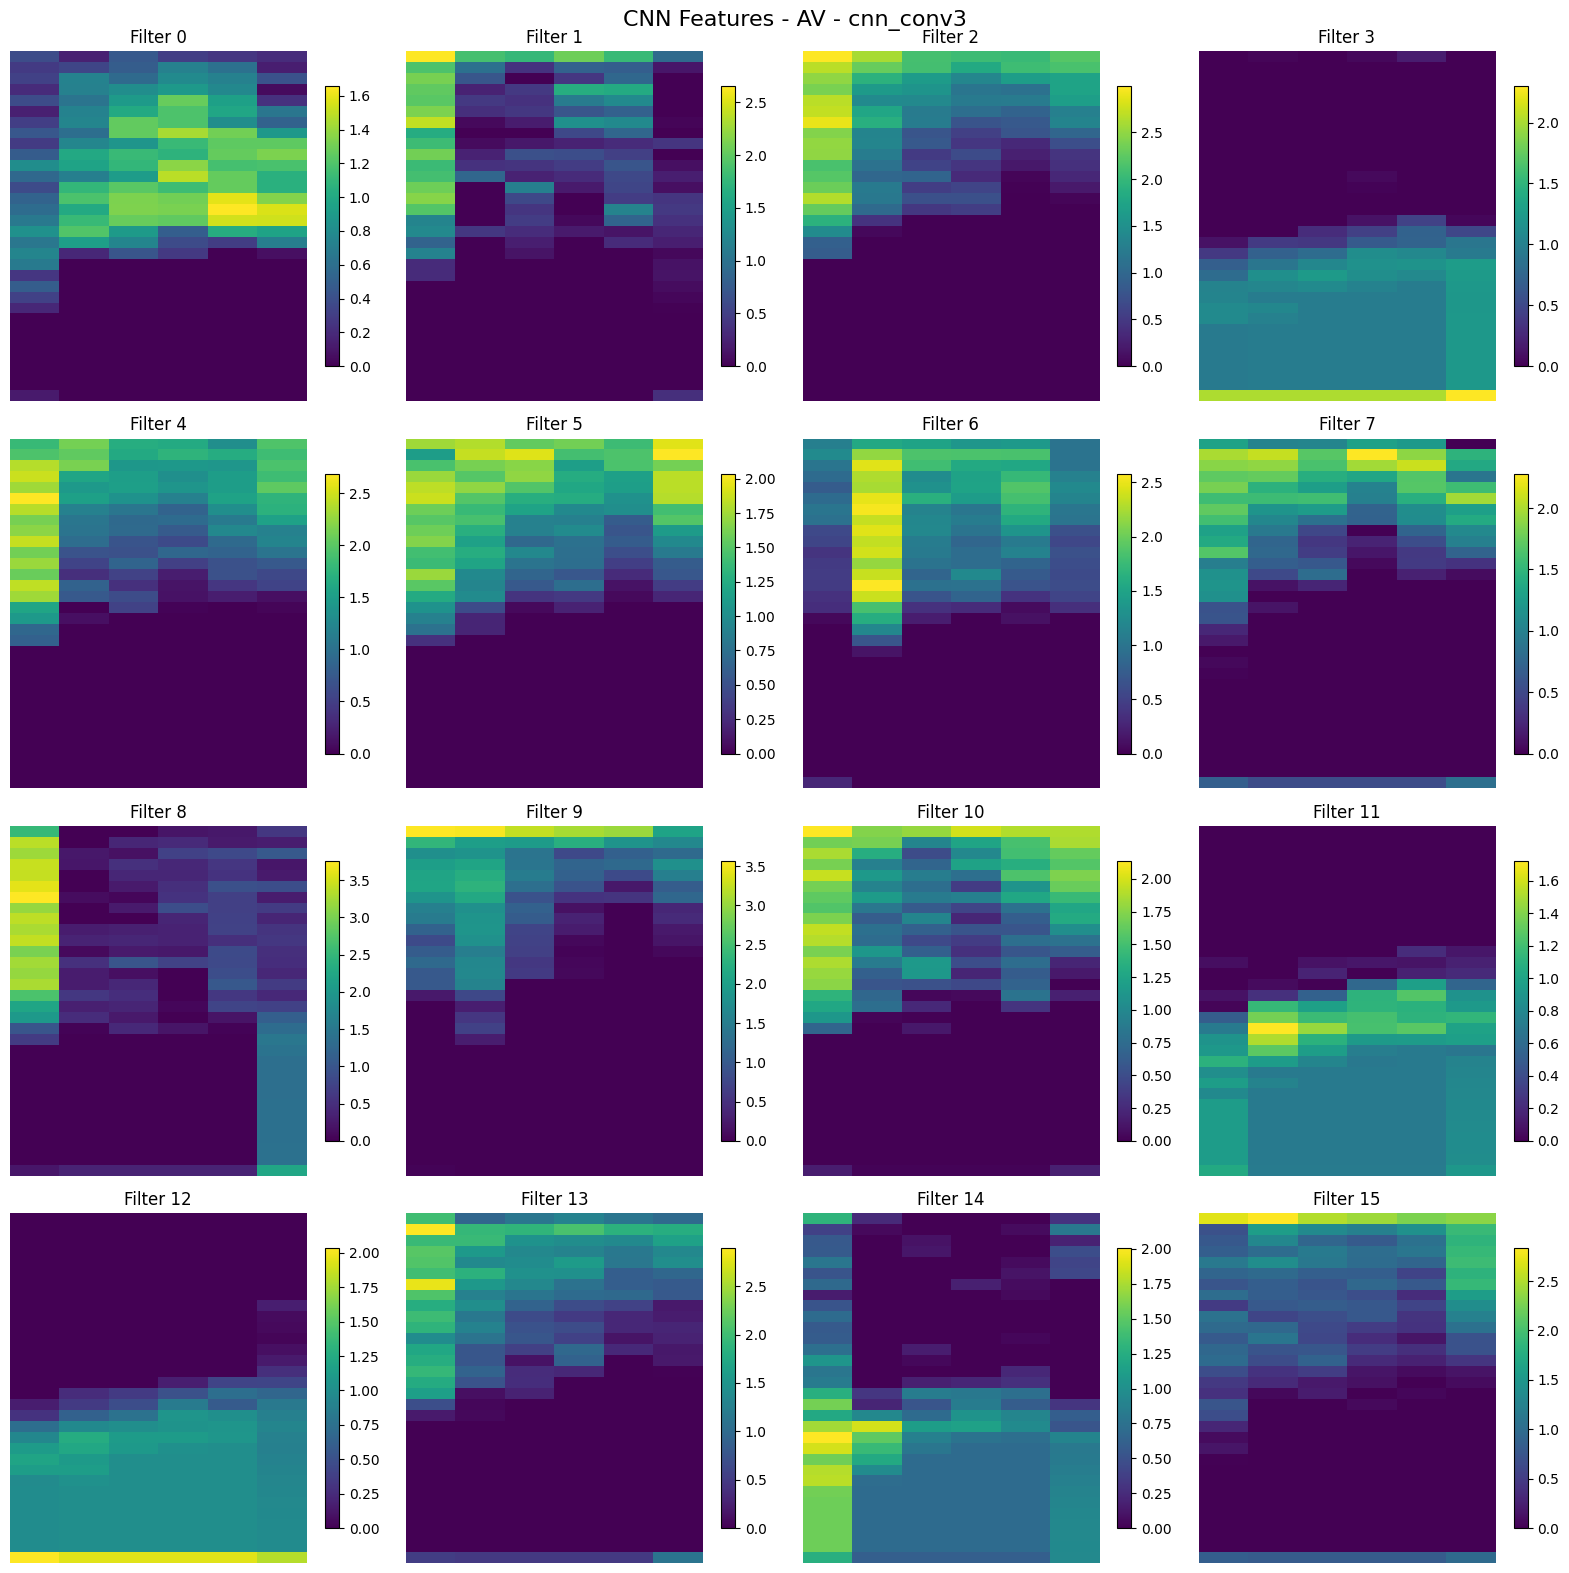

In [ ]:
viz.visualize_cnn_features(sample_idx=0, location='AV', layer_name='cnn_conv3')